In [1]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 81.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 63.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 75.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [matplotlib]6 [matplotlib]
Note: you may need to restart the kernel to use updated packages.


In [4]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [5]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))   # maps [0,1] → [-1,1]
])

mnist = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
loader = torch.utils.data.DataLoader(mnist, batch_size=8, shuffle=True)

In [ ]:
class Forward: # Le truc du processus qui se calcule vous embêtez pas avec ça
    def __init__(self, lambda_=1.0):
        self.lmbd = lambda_

    def mean(self, x0, t):
        # x0: [B,1,28,28], t: [B] 
        t = t[:, None, None, None] # Trucs de cast de tenseur à la bonne dimension
        return x0 * torch.exp(-self.lmbd * t)          

    def std(self, t):
        t = t[:, None, None, None]
        std = torch.sqrt(1.0 - torch.exp(-2 * self.lmbd * t))
        return std.clamp(min=1e-3) # On utilise ça pour éviter les blow up numériques quand on divise par ça 

    def diffusion_coeff(self, t):
        return (2 * self.lmbd) ** 0.5 * torch.ones_like(t)


def sample_noisy(x0, t, sde): # Renvoie x_t |x_0 image bruitée
    mean = sde.mean(x0, t)
    std = sde.std(t)
    eps = torch.randn_like(x0)
    return mean + std * eps


def conditional_score(x0, xt, t, sde): # Gradient conditionnel calcul
    mean = sde.mean(x0, t)
    std = sde.std(t)                      # already clamped
    return -(xt - mean) / (std ** 2)      # Gaussian score


In [ ]:
x0, _ = next(iter(loader))  # x0 shape: [8,1,28,28]

t = torch.rand(x0.size(0)) # Loi uniforme dans [0,1]
t = t 
sde = Forward(lambda_=1.0)

# sample noisy images
xt = sample_noisy(x0, t, sde)

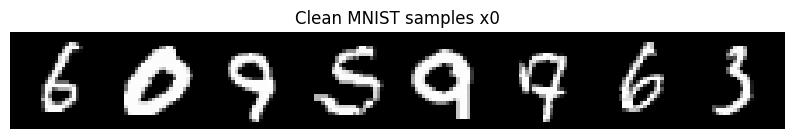

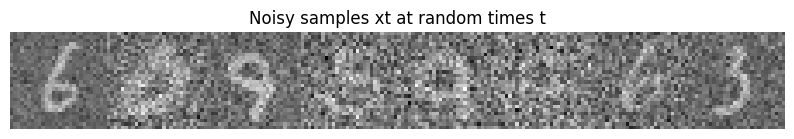

In [ ]:
def show_images(x, title): # Visualisation du forward
    x = x.detach().cpu()
    grid = torch.cat([x[i] for i in range(x.size(0))], dim=2)
    plt.figure(figsize=(10,2))
    plt.imshow(grid.squeeze(), cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

show_images(x0, "Clean MNIST samples x0")
show_images(xt, "Noisy samples xt at random times t")


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# simple sinusoidal embedding for t
class TimeEmbedding(nn.Module):
    def __init__(self, dim=32):
        super().__init__()
        self.dim = dim
        self.lin = nn.Linear(dim, dim)

    def forward(self, t):
        # t: shape [batch]
        half_dim = self.dim // 2
        emb = torch.exp(
            torch.arange(half_dim, device=t.device) * -(torch.log(torch.tensor(10000.0)) / half_dim)
        )
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return self.lin(emb)  # [batch, dim]

class ConvBlock(nn.Module): # Définition des trucs de convolution dans le CNN
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)


class UNetScore(nn.Module): # Création d'un U-Net c'est un CNN en mieux pour ce problème
    def __init__(self, time_dim=32, base_channels=64):
        super().__init__()
        self.time_mlp = TimeEmbedding(dim=time_dim)

        in_ch = 1 + time_dim  # 1 image channel + time embedding

        # Encoder
        self.down1 = ConvBlock(in_ch, base_channels)               # 28x28
        self.pool1 = nn.MaxPool2d(2)                               # 28→14

        self.down2 = ConvBlock(base_channels, base_channels * 2)   # 14x14
        self.pool2 = nn.MaxPool2d(2)                               # 14→7

        # Bottleneck
        self.bottleneck = ConvBlock(base_channels * 2, base_channels * 4)  # 7x7

        # Decoder
        self.up2 = nn.ConvTranspose2d(base_channels * 4, base_channels * 2,
                                      kernel_size=2, stride=2)     # 7→14
        self.dec2 = ConvBlock(base_channels * 4, base_channels * 2) # concat skip

        self.up1 = nn.ConvTranspose2d(base_channels * 2, base_channels,
                                      kernel_size=2, stride=2)     # 14→28
        self.dec1 = ConvBlock(base_channels * 2, base_channels)

        # Final output: 1 channel (score)
        self.out_conv = nn.Conv2d(base_channels, 1, kernel_size=3, padding=1)

    def forward(self, x, t):
        # Time embedding → [B, time_dim, H, W]
        emb = self.time_mlp(t)              # [B, time_dim]
        emb = emb[:, :, None, None]         # [B, time_dim, 1, 1]
        emb = emb.expand(-1, -1, x.size(2), x.size(3))

        x_in = torch.cat([x, emb], dim=1)   # [B, 1+time_dim, 28, 28]

        # Encoder
        d1 = self.down1(x_in)               # [B, C, 28, 28]
        p1 = self.pool1(d1)                 # [B, C, 14, 14]

        d2 = self.down2(p1)                 # [B, 2C, 14, 14]
        p2 = self.pool2(d2)                 # [B, 2C, 7, 7]

        # Bottleneck
        b = self.bottleneck(p2)             # [B, 4C, 7, 7]

        # Decoder
        u2 = self.up2(b)                    # [B, 2C, 14, 14]
        u2 = torch.cat([u2, d2], dim=1)     # [B, 4C, 14, 14]
        d2_dec = self.dec2(u2)              # [B, 2C, 14, 14]

        u1 = self.up1(d2_dec)               # [B, C, 28, 28]
        u1 = torch.cat([u1, d1], dim=1)     # [B, 2C, 28, 28]
        d1_dec = self.dec1(u1)              # [B, C, 28, 28]

        out = self.out_conv(d1_dec)         # [B, 1, 28, 28]
        return out
    

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu" # Vérifiez bien que vous soyez avec support GPU  

sde = Forward(lambda_=1.0)
model = UNetScore(time_dim=32, base_channels=64).to(device)

import torch.optim as optim
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

t_min = 0.02      # éviter le blow up numérique du gradient
num_epochs = 50   # 50 c'est bien même un peu trop peut être 35 sans doute suffisant

for epoch in range(num_epochs):
    epoch_loss = 0.0
    n_batches = 0

    for x0, _ in loader:
        x0 = x0.to(device)

        # t ∈ [t_min, 1]
        t = t_min + (1.0 - t_min) * torch.rand(x0.size(0), device=device)

        xt = sample_noisy(x0, t, sde)
        target = conditional_score(x0, xt, t, sde)
        pred = model(xt, t)

        loss = F.mse_loss(pred, target)

        if torch.isnan(loss):
            print("NaN loss, abort")
            raise SystemExit

        optimizer.zero_grad()
        loss.backward()
        # optionel parce que déjà clamp mais pour la stabilité c'est bien apparemment
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        epoch_loss += loss.item()
        n_batches += 1

    print(f"Epoch {epoch+1}: mean loss = {epoch_loss / n_batches:.4f}")


Epoch 1: mean loss = 0.2653
Epoch 2: mean loss = 0.1468
Epoch 3: mean loss = 0.1330
Epoch 4: mean loss = 0.1233
Epoch 5: mean loss = 0.1223
Epoch 6: mean loss = 0.1178
Epoch 7: mean loss = 0.1167
Epoch 8: mean loss = 0.1163
Epoch 9: mean loss = 0.1154
Epoch 10: mean loss = 0.1128
Epoch 11: mean loss = 0.1135
Epoch 12: mean loss = 0.1109
Epoch 13: mean loss = 0.1118
Epoch 14: mean loss = 0.1107
Epoch 15: mean loss = 0.1106
Epoch 16: mean loss = 0.1096
Epoch 17: mean loss = 0.1078
Epoch 18: mean loss = 0.1098
Epoch 19: mean loss = 0.1099
Epoch 20: mean loss = 0.1089
Epoch 21: mean loss = 0.1067
Epoch 22: mean loss = 0.1081
Epoch 23: mean loss = 0.1066
Epoch 24: mean loss = 0.1056
Epoch 25: mean loss = 0.1050
Epoch 26: mean loss = 0.1071
Epoch 27: mean loss = 0.1066
Epoch 28: mean loss = 0.1075
Epoch 29: mean loss = 0.1061
Epoch 30: mean loss = 0.1046
Epoch 31: mean loss = 0.1045
Epoch 32: mean loss = 0.1048
Epoch 33: mean loss = 0.1049
Epoch 34: mean loss = 0.1035
Epoch 35: mean loss = 0

In [ ]:
@torch.no_grad()
def sample_reverse_euler_maruyama(model, sde, num_steps=500, batch_size=16, device="cuda", t_min=0.02): # C'est le solver numérique du reverse
    model.eval()

    T = 1.0
    # times from T down to t_min
    t_grid = torch.linspace(T, t_min, num_steps, device=device)  # [N]

    # start from prior ≈ N(0, I)
    x = torch.randn(batch_size, 1, 28, 28, device=device)

    for i in range(num_steps - 1):
        t_cur = t_grid[i]
        t_next = t_grid[i + 1]
        dt = t_next - t_cur          # NOTE: dt < 0

        t_batch = torch.full((batch_size,), t_cur, device=device)

        g = sde.diffusion_coeff(t_batch)    # [B]
        g2 = g ** 2
        g = g.view(batch_size, 1, 1, 1)
        g2 = g2.view(batch_size, 1, 1, 1)

        score = model(x, t_batch)          # [B,1,28,28]
        drift = -sde.lmbd * x - g2 * score # f - g^2 s_theta

        noise = torch.randn_like(x)
        x = x + drift * dt + g * torch.sqrt(-dt) * noise # C'est le step de résolution backwards

        if torch.isnan(x).any() or torch.isinf(x).any():
            print("NaNs/Infs at step", i)
            break

    return x


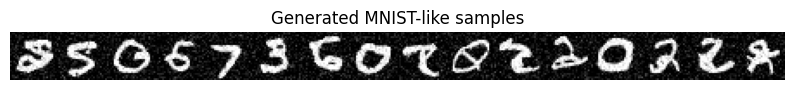

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu" # La génération et la visualisation est faite ici
sde = Forward(lambda_=1.0)
model = model.to(device)  # your trained model

samples = sample_reverse_euler_maruyama(model, sde, num_steps=500, batch_size=16, device=device)

# inverse normalize from [-1,1] back to [0,1] if you used that normalization
samples = (samples.clamp(-1, 1) + 1) / 2.0

import matplotlib.pyplot as plt

def show_batch(x, title="Samples"):
    x = x.detach().cpu()
    grid = torch.cat([x[i] for i in range(x.size(0))], dim=2)
    plt.figure(figsize=(10, 2))
    plt.imshow(grid.squeeze(), cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

show_batch(samples, "Generated MNIST-like samples")

In [17]:
state = {
    "epoch": epoch,
    "model_state": model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
}
torch.save(state, "mnist_diffusion_checkpoint.pth") # Pour save le résultat du training chez vous